In [1]:
!pip install grakel sklearn numpy scipy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 839.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.5 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=eaa1742b37c59f1d23c1084ef5309445c9e275debdac01c821eb1d0be6455861
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
# Note: Grakel does not seem to support Python >=3.10, Python 3.9 works fine

## Base imports
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA  # to check your own implementation
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math

## Additionals imports
import seaborn as sns
from grakel import Graph
import time

In [3]:
# Some datasets, more datasets here https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets

"""
    The MUTAG dataset consists of 188 chemical compounds divided into two 
    classes according to their mutagenic effect on a bacterium. 

    The chemical data was obtained form http://cdb.ics.uci.edu and converted 
    to graphs, where vertices represent atoms and edges represent chemical 
    bonds. Explicit hydrogen atoms have been removed and vertices are labeled
    by atom type and edges by bond type (single, double, triple or aromatic).
    Chemical data was processed using the Chemistry Development Kit (v1.4).
"""

"""
    ENZYMES is a dataset of protein tertiary structures obtained from (Borgwardt et al., 2005) 
    consisting of 600 enzymes from the BRENDA enzyme database (Schomburg et al., 2004). 
    In this case the task is to correctly assign each enzyme to one of the 6 EC top-level 
    classes. 
"""

"""
    NCI1 and NCI109 represent two balanced subsets of datasets of chemical compounds screened 
    for activity against non-small cell lung cancer and ovarian cancer cell lines respectively
    (Wale and Karypis (2006) and http://pubchem.ncbi.nlm.nih.gov).
"""

dataset1 = fetch_dataset("MUTAG", verbose=False) # "MUTAG", "ENZYMES", "NCI1"
G1 = dataset1.data ## ( Unidirected edges, labels, (edges type) )
y1 = dataset1.target
print(len(y1))
dataset2 = fetch_dataset("ENZYMES", verbose=False) # "MUTAG", "ENZYMES", "NCI1"
G2 = dataset2.data ## ( Unidirected edges, labels, (edges type) )
y2 = dataset2.target
print(len(y2))
dataset3 = fetch_dataset("NCI1", verbose=False) # "MUTAG", "ENZYMES", "NCI1"
G3 = dataset3.data ## ( Unidirected edges, labels, (edges type) )
y3 = dataset3.target
print(len(y3))


188
600
4110


## Computing the Kernel

### Compute de kernels
Using the Grakel library, compute the pairwise kernels between all the graphs in the dataset (for an arbitrary number of iteration H). 

Source:
- [Grakel introduction](https://ysig.github.io/GraKeL/0.1a8/documentation/introduction.html)
- [Weisfeiler Lehman Framework](https://ysig.github.io/GraKeL/0.1a8/kernels/weisfeiler_lehman.html#shervashidze2011weisfeiler)
- [grakel.WeisfeilerLehman](https://ysig.github.io/GraKeL/0.1a8/generated/grakel.WeisfeilerLehman.html#grakel.WeisfeilerLehman)

In [4]:
def pairwise(G,h=10):
    t0 = time.time()
    ## Initialisation du framework
    wl_kernel = WeisfeilerLehman(n_iter=h, normalize=False, base_graph_kernel=VertexHistogram)
    pkm = wl_kernel.fit_transform(G)
    print("Exc. time: " + str(round(time.time()-t0,1)) + ' sec.')
    return pkm

wlm1 = pairwise(G1) #WL subtree matrix 1
wlm2 = pairwise(G2)
wlm3 = pairwise(G3)

Exc. time: 0.1 sec.
Exc. time: 1.0 sec.
Exc. time: 6.9 sec.


### Explicit embedding versus kernel
A justification for the use of kernels is that the implicit embedding space has more dimensions than the number samples in the datasets, and thus, it is computationally easier to work with the kernels.
Compute the rank of the WL subtree kernel matrix for the three datasets and H = 10 iterations.
Then infer and justify a lower-bound on the dimension of the implicit embedding space based on these ranks.

In [5]:
print("rank for WL subtree kernel matrix of MUTAG dataset: " +str(np.linalg.matrix_rank(wlm1)))
print("rank for WL subtree kernel matrix of ENZYMES dataset: " +str(np.linalg.matrix_rank(wlm2)))
print("rank for WL subtree kernel matrix of NCI1 dataset: " +str(np.linalg.matrix_rank(wlm3)))

rank for WL subtree kernel matrix of MUTAG dataset: 175
rank for WL subtree kernel matrix of ENZYMES dataset: 595


KeyboardInterrupt: 

## Visualization

### Kernel centralization

In [6]:
def centering(K):
    one_m = np.ones((len(K), len(K))) / len(K)
    Kt = K - one_m.dot(K) - K.dot(one_m) + (one_m.dot(K)).dot(one_m)

    return Kt

print(round(centering(wlm1).mean(),10)) ## expecting 0
print(round(centering(wlm2).mean(),10))
print(round(centering(wlm2).mean(),10))

0.0
0.0
0.0


### Kernel-PCA implementation
Refer to the slides to implement kernel-PCA from scratch given a precomputed centered kernel matrix.

In [7]:
def kPCA_own(wlm):
    K = centering(wlm) # centering

    l , v = np.linalg.eigh(K) # ascending order
    l, v = l[::-1], v[:, ::-1]  # descending order
    u = np.sqrt(l[:2]) * v[:,:2]  # Scaling

    print(f"U shape: {u.shape}")
    return u

u1 = kPCA_own(wlm1)
u2 = kPCA_own(wlm2)
u3 = kPCA_own(wlm3)

U shape: (188, 2)
U shape: (600, 2)
U shape: (4110, 2)


### Kernel-PCA visualization
Plot the graphs using the 2-dimensional embeddings defined by the two first principal components.

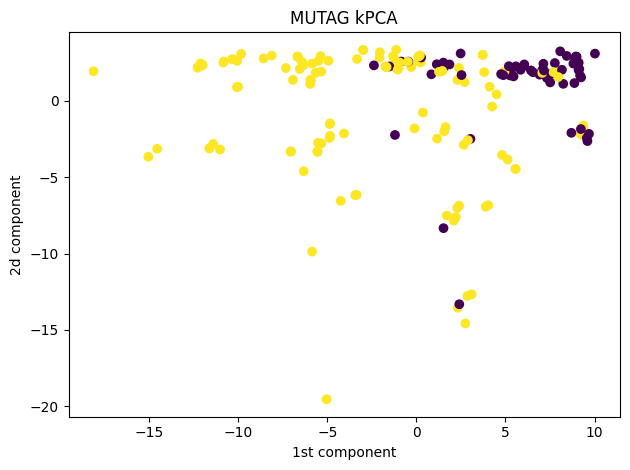

In [8]:
plt.figure()
plt.scatter(u1[:,0] , u1[:,1], c=y1)
plt.title("MUTAG kPCA")
plt.xlabel('1st component')
plt.ylabel('2d component')
plt.tight_layout()
plt.show()

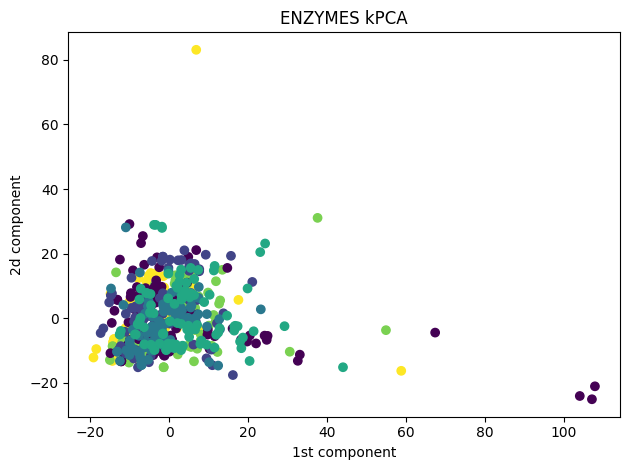

In [9]:
plt.figure()
plt.scatter(u2[:,0] , u2[:,1], c=y2)
plt.title("ENZYMES kPCA")
plt.xlabel('1st component')
plt.ylabel('2d component')
plt.tight_layout()
plt.show()

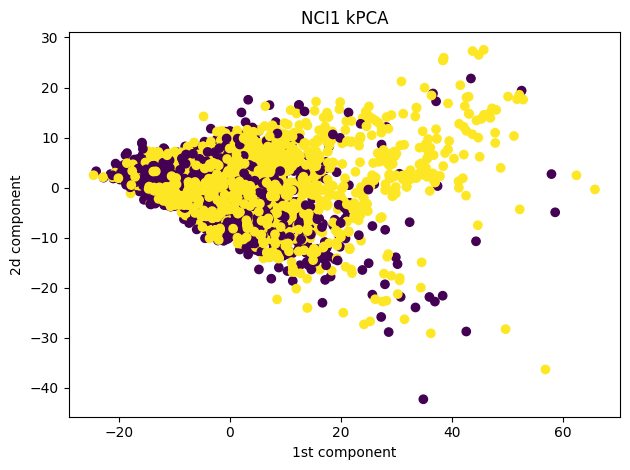

In [10]:
plt.figure()
plt.scatter(u3[:,0] , u3[:,1], c=y3)
plt.title("NCI1 kPCA")
plt.xlabel('1st component')
plt.ylabel('2d component')
plt.tight_layout()
plt.show()

### Distance

In [13]:
from math import sqrt
def Eucl(K):
    n = len(K)
    E = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            E[i,j] = sqrt(K[i,i] + K[j,j] - 2*K[i,j] )
    return E

In [14]:
edm1 = Eucl(wlm1) # euclidean distance matrix
edm2 = Eucl(wlm2) # euclidean distance matrix
edm3 = Eucl(wlm3) # euclidean distance matrix

### tSNE
Relying on the pairwise distances just computed, apply tSNE using Scikit-learn. Explain briefly tSNE. (You have to do your own research for this method.) [ici](https://towardsdatascience.com/t-sne-python-example-1ded9953f26)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


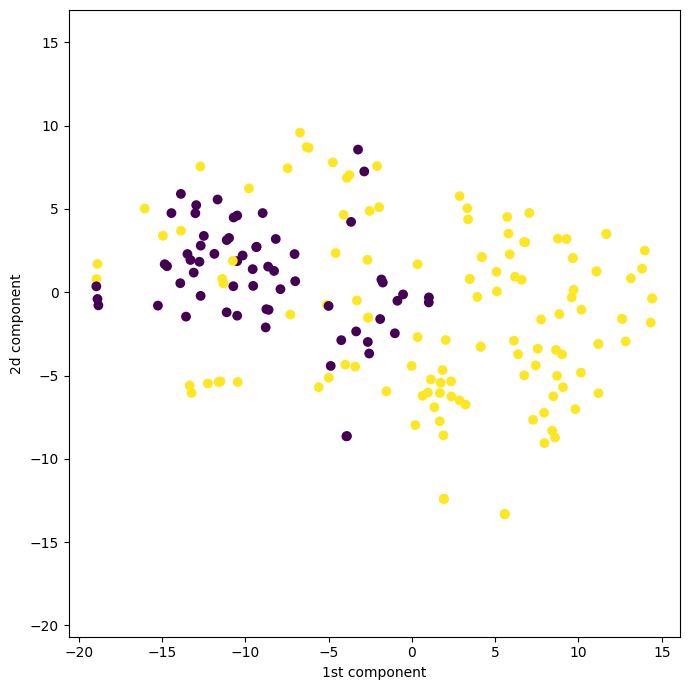

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


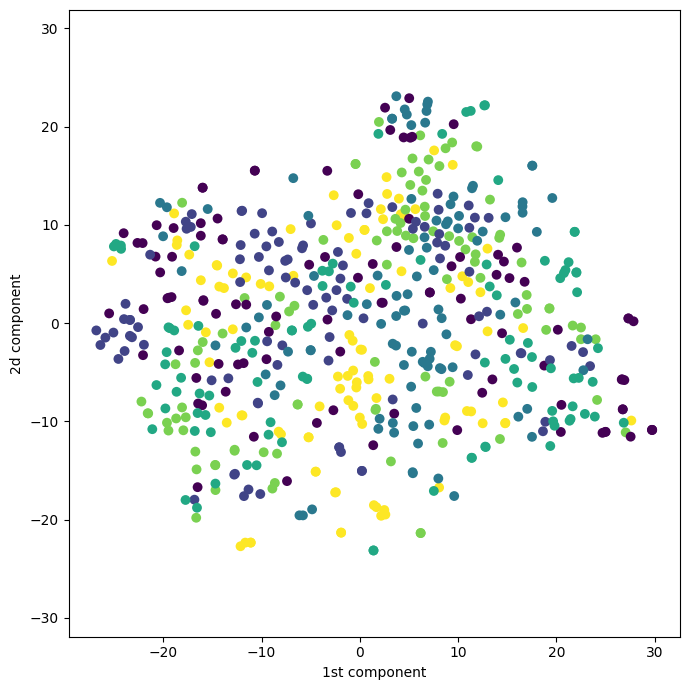

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


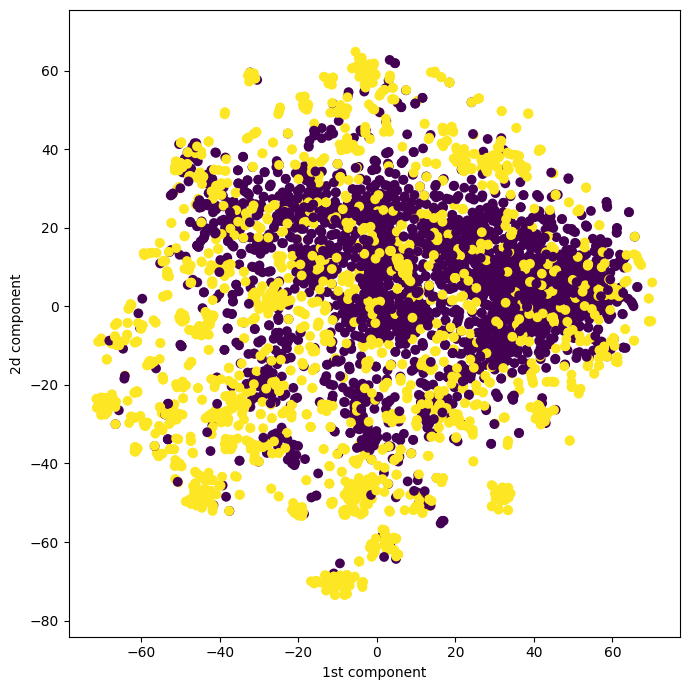

In [15]:
from sklearn.preprocessing import normalize
from sklearn import manifold
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

def own_tsne(distances_matrix, y):
    
    model = manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
    coords = model.fit_transform(distances_matrix)

    plt.figure(figsize=(7, 7))
    plt.scatter(coords[:, 0], coords[:, 1], marker='o', c=y, s=50, edgecolor='None')
    plt.xlabel('1st component')
    plt.ylabel('2d component')
    plt.tight_layout()
    plt.axis('equal')
    plt.show()

own_tsne(edm1, y1)
own_tsne(edm2, y2)
own_tsne(edm3, y3)

## Classification

### Simple baseline
Estimate the accuracy of the best constant model on the three datasets. A constant model always output the same class without even looking at the input.

In [16]:
from collections import Counter
def base_accuracy(y):
    base_y = Counter(y)
    print(base_y)
    n = len(y)
    n_max = max(base_y.values())
    acc = (n_max / n)
    return acc

print(f'Base accuracy for MUTAG: {base_accuracy(y1):.3f}')
print(f'Base accuracy for ENZYMES: {base_accuracy(y2):.3f}')
print(f'Base accuracy for NC1I: {base_accuracy(y3):.3f}')

Counter({1: 125, -1: 63})
Base accuracy for MUTAG: 0.665
Counter({6: 100, 5: 100, 1: 100, 2: 100, 3: 100, 4: 100})
Base accuracy for ENZYMES: 0.167
Counter({1: 2057, 0: 2053})
Base accuracy for NC1I: 0.500


### SVM
Split the dataset into a training and a testing partition (80/20).
Find an optimal SVM classifier with the WL subtree kernel on the training dataset. You can use the Scikit-learn
library. The hyperparameters, we will consider, are C which inverse proportionally weight a quadratic regularization on the parameters and H the number of iterations in the WL subtree kernel. You can set C = 1e2 and H = 3 for this first model.
Assess the accuracy of your model on the test partition.

In [5]:
def SVM_own(G, Y, C, H):
    tik = time.perf_counter()
    G_train, G_test, y_train, y_test =  train_test_split(G, Y, test_size=0.20, random_state=0)

    wl_kernel = WeisfeilerLehman(n_iter= H, base_graph_kernel=VertexHistogram)
    K_train = wl_kernel.fit_transform(G_train)
    K_test = wl_kernel.transform(G_test)
    
    lsvm = SVC(C=C,kernel='precomputed')
    lsvm.fit(K_train, y_train)
    pred = lsvm.predict(K_test)

    cv_time = time.perf_counter() - tik
    print(f'SVM Exc. time: {cv_time:.3f} sec. ----  Acc={accuracy_score(pred, y_test):.3f}')
    return accuracy_score(pred, y_test)

In [6]:
SVM_own(G1, y1, C=0.01, H=3)
SVM_own(G2, y2, C=0.01, H=3)
SVM_own(G3, y3, C=0.01, H=3)

SVM Exc. time: 0.049 sec. ----  Acc=0.816
SVM Exc. time: 0.397 sec. ----  Acc=0.483
SVM Exc. time: 2.330 sec. ----  Acc=0.826


0.8260340632603407

### Select hyperparameter
Perform a grid search over the space of hyperparameters C = {1e−5, 1e−4, . . . , 1e4}, H = {1, 2, . . . , 10} and select the best combination according to its performance on a 10-fold cross validation on the previously isolated training set. You can use Scikit-learn cross val score function to help you3.

In [7]:
c_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
h_values = [1,2,3,4,5,6,7,8,9,10]

def hyper(G, y, c_values=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2], h_values=[1,2,3,4,5,6,7,8,9,10] ):

    tik = time.perf_counter()
    hyp_matrix = pd.DataFrame(np.zeros((len(h_values), len(c_values))), index=h_values, columns=c_values)

    for i, h in enumerate(h_values):
        #print(f'H={h}')

        wl_kernel = WeisfeilerLehman(n_iter= h, base_graph_kernel=VertexHistogram)
        K = wl_kernel.fit_transform(G)

        for j,c in enumerate(c_values):
            tikk= time.perf_counter()
            lsvm = SVC(C=c,kernel='precomputed')
            hyp_matrix.iloc[i,j] = cross_val_score(lsvm, K, y, cv=10).mean()
            cvv_time = time.perf_counter() - tikk
            #print(f'[H={h};C={c}] : acc= {hyp_matrix.iloc[i,j]:.3f} ({cvv_time:.3f} sec.)')
    cv_time = time.perf_counter() - tik
    print(f'Total Hyper Exc. time: {cv_time:.3f} sec.')
    print(f'Best hyperparamters: {hyp_matrix.stack().index[np.argmax(hyp_matrix.values)]} with acc={np.max(hyp_matrix.values):.3f}')
    return hyp_matrix



Total Hyper Exc. time: 1.804 sec.
Best hyperparamters: (1, 1.0) with acc=0.893


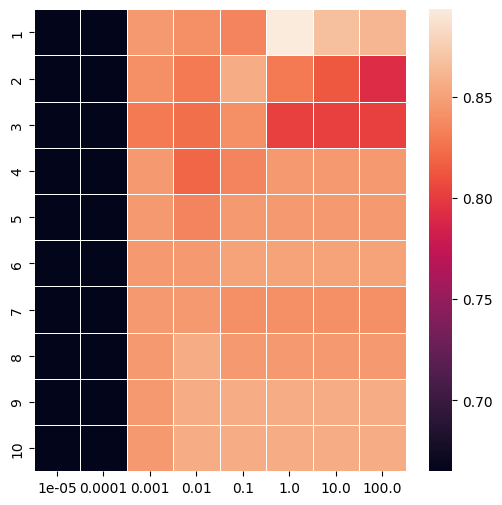

In [11]:
plt.figure(figsize=(6,6))
sns.heatmap(hyper(G1,y1), linewidth=0.5)
plt.show()

Total Hyper Exc. time: 218.673 sec.
Best hyperparamters: (3, 0.1) with acc=0.343


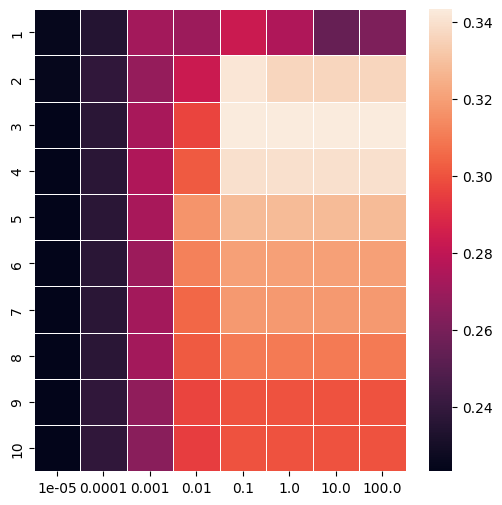

In [13]:
plt.figure(figsize=(6,6))
sns.heatmap(hyper(G2,y2), linewidth=0.5)
plt.show()

Total Hyper Exc. time: 5425.150 sec.
Best hyperparamters: (8, 0.01) with acc=0.816


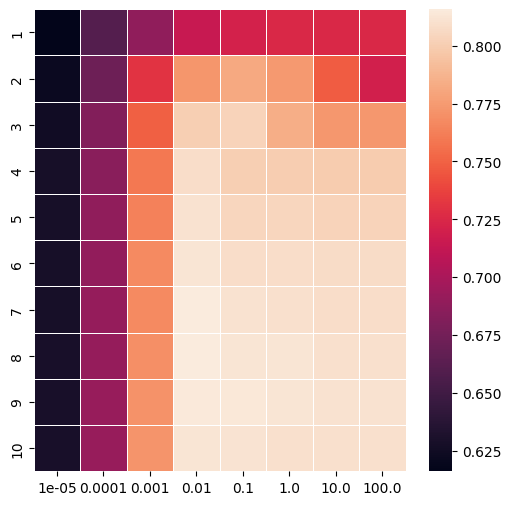

In [8]:
plt.figure(figsize=(6,6))
sns.heatmap(hyper(G3,y3), linewidth=0.5)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a9ed9f84-fe38-4268-9cae-f8232cc183f9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>